In [1]:
#!pip install  pyarrow   --upgrade
#!pip install --extra-index-url https://test.pypi.org/simple/ datafusion==51.0.0
!pip install  -q pandas    --upgrade
!pip install  -q duckdb    --upgrade
!pip install  -q polars    --upgrade
!pip install  -q chdb      --pre --upgrade
!pip install  -q deltalake --upgrade
!pip install  -q daft
import sys
sys.exit(0)

In [2]:
engine ='polars'

In [3]:
# This cell is generated from runtime parameters. Learn more: https://go.microsoft.com/fwlink/?linkid=2161015
engine = "chdb"


In [4]:
total_files  = 2840

In [5]:
Source        = "/lakehouse/default/Files/zip/"
Destination   = "/lakehouse/default/Files/csv/"
table_root    = 'abfss://tpch@onelake.dfs.fabric.microsoft.com/storage.Lakehouse/Tables'
test_resuts   = 'abfss://sqlengines@onelake.dfs.fabric.microsoft.com/ETL.Lakehouse/Tables/dbo/results'

_**Import**_

In [6]:
import pandas            as pd
import pyarrow           as pa
from   deltalake         import DeltaTable
from   datetime          import datetime
from   deltalake.writer  import write_deltalake
from   shutil            import unpack_archive
from   urllib.request    import urlopen
from   psutil            import *
import duckdb
import time
import glob
import os
import re 
import requests
import multiprocessing

In [7]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:15.0


# Download Data

In [8]:
def get_all_zip_files_api(owner, repo, path):
    """Use GitHub API to recursively find all zip files"""
    all_zips = []
    api_url = f'https://api.github.com/repos/{owner}/{repo}/contents/{path}'
    
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        items = response.json()
        
        for item in items:
            if item['type'] == 'dir':
                # Recursively get files from subdirectories
                subdir_zips = get_all_zip_files_api(owner, repo, item['path'])
                all_zips.extend(subdir_zips)
            elif item['type'] == 'file' and item['name'].endswith('.zip'):
                # Add the download URL for this zip file
                all_zips.append({
                    'name': item['name'],
                    'path': item['path'],
                    'download_url': item['download_url']
                })
    except Exception as e:
        print(f"Error accessing {api_url}: {e}")
    
    return all_zips

def download(Path, total_files):
    if not os.path.exists(Path):
        os.makedirs(Path, exist_ok=True)
    
    # Get all zip files using GitHub API
    print("Fetching file list from GitHub...")
    
    current = [os.path.basename(x) for x in glob.glob(os.path.join(Path, '*.zip'))]
    
    # Check if folder already has the requested number of files
    if len(current) >= total_files:
        print(f"Folder already has {len(current)} file(s). No download needed.")
        return "done"
    
    filelist = get_all_zip_files_api('djouallah', 'fabric_demo', 'data/archive')
    filelist = sorted(filelist, key=lambda x: x['name'], reverse=True)
    
    # Calculate how many more files are needed
    files_needed = total_files - len(current)
    files_to_upload = [f for f in filelist if f['name'] not in current][:files_needed]
    
    print(f"{len(files_to_upload)} New File(s) to Download")
    
    if len(files_to_upload) > 0:
        for file_info in files_to_upload:
            filename = file_info['name']
            download_url = file_info['download_url']
            print(f"Downloading {filename}...")
            
            try:
                with requests.get(download_url, stream=True) as resp:
                    resp.raise_for_status()
                    with open(os.path.join(Path, filename), "wb") as f:
                        for chunk in resp.iter_content(chunk_size=8192):
                            f.write(chunk)
                print(f"  ✓ {filename} downloaded successfully")
            except Exception as e:
                print(f"  ✗ Failed to download {filename}: {e}")
    
    return "done"

In [9]:
def uncompress(x):
        unpack_archive(str(Source+x), str(Destination), 'zip')
def unzip(Source, Destination,Nbr_Files_to_Download):
    if not os.path.exists(Destination):
      os.makedirs(Destination, exist_ok=True)
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    ### checl the unzipped files already
    current = [os.path.basename(x) for x in glob.glob(Destination+'*.CSV')]
    current = [w.replace('.CSV','.zip') for w in current]
    #unzip only the delta
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))
    print(str(len(files_to_upload)) + ' New File uncompressed')
    if len(files_to_upload) != 0 :
      with multiprocessing.Pool() as pool:
       for _ in pool.imap_unordered(uncompress, files_to_upload, chunksize=1):
         pass
      return "done"
    else:
     return "nothing to see here"

# Polars

In [10]:
def polars_clean_csv(files_to_upload_full_Path):
    import polars as pl
    
    storage_options = {
        "bearer_token": notebookutils.credentials.getToken('storage'),
        "use_fabric_endpoint": "true"
    }
    
    schema = {
        'I': pl.String, 'UNIT': pl.String, 'XX': pl.String, 'VERSION': pl.String,
        'SETTLEMENTDATE': pl.String, 'RUNNO': pl.String, 'DUID': pl.String,
        'INTERVENTION': pl.String, 'DISPATCHMODE': pl.String, 'AGCSTATUS': pl.String,
        'INITIALMW': pl.String, 'TOTALCLEARED': pl.String, 'RAMPDOWNRATE': pl.String,
        'RAMPUPRATE': pl.String, 'LOWER5MIN': pl.String, 'LOWER60SEC': pl.String,
        'LOWER6SEC': pl.String, 'RAISE5MIN': pl.String, 'RAISE60SEC': pl.String,
        'RAISE6SEC': pl.String, 'MARGINAL5MINVALUE': pl.String, 'MARGINAL60SECVALUE': pl.String,
        'MARGINAL6SECVALUE': pl.String, 'MARGINALVALUE': pl.String, 'VIOLATION5MINDEGREE': pl.String,
        'VIOLATION60SECDEGREE': pl.String, 'VIOLATION6SECDEGREE': pl.String, 'VIOLATIONDEGREE': pl.String,
        'LOWERREG': pl.String, 'RAISEREG': pl.String, 'AVAILABILITY': pl.String,
        'RAISE6SECFLAGS': pl.String, 'RAISE60SECFLAGS': pl.String, 'RAISE5MINFLAGS': pl.String,
        'RAISEREGFLAGS': pl.String, 'LOWER6SECFLAGS': pl.String, 'LOWER60SECFLAGS': pl.String,
        'LOWER5MINFLAGS': pl.String, 'LOWERREGFLAGS': pl.String, 'RAISEREGAVAILABILITY': pl.String,
        'RAISEREGENABLEMENTMAX': pl.String, 'RAISEREGENABLEMENTMIN': pl.String,
        'LOWERREGAVAILABILITY': pl.String, 'LOWERREGENABLEMENTMAX': pl.String,
        'LOWERREGENABLEMENTMIN': pl.String, 'RAISE6SECACTUALAVAILABILITY': pl.String,
        'RAISE60SECACTUALAVAILABILITY': pl.String, 'RAISE5MINACTUALAVAILABILITY': pl.String,
        'RAISEREGACTUALAVAILABILITY': pl.String, 'LOWER6SECACTUALAVAILABILITY': pl.String,
        'LOWER60SECACTUALAVAILABILITY': pl.String, 'LOWER5MINACTUALAVAILABILITY': pl.String,
        'LOWERREGACTUALAVAILABILITY': pl.String
    }
    
    raw = pl.scan_csv(
        files_to_upload_full_Path, 
        skip_rows=1, 
        schema=schema, 
        has_header=False,
        truncate_ragged_lines=True, 
        include_file_paths="filename",
        ignore_errors=True
    )
    
    transform = (
        raw
        .filter((pl.col("I") == 'D') & (pl.col("UNIT") == 'DUNIT') & (pl.col("VERSION") == '3'))
        .drop("XX", "I", "VERSION")
    )
    
    columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE', 'DUID', 'UNIT', 'filename'})
    
    final = (
        transform
        .with_columns([
            pl.col("SETTLEMENTDATE").str.to_datetime("%Y/%m/%d %H:%M:%S"),
            *[pl.col(col).cast(pl.Float64) for col in columns],
            pl.col("SETTLEMENTDATE").str.to_datetime("%Y/%m/%d %H:%M:%S").dt.year().alias("year")
        ])
    )
    
    final.sink_delta(
        f"{table_root}/T{len(files_to_upload_full_Path)}/polars",
        mode="append",
        delta_write_options={"partition_by": "year"},
        storage_options=storage_options
    )
    
    return "done"

# DuckDB

In [11]:
def duckdb_clean_csv(files_to_upload_full_Path):
	con = duckdb.connect()
	df = con.sql(F"""
	SET preserve_insertion_order = false;
    with raw as (
	select * from read_csv({files_to_upload_full_Path},
	Skip=1,header =0,all_varchar=1,
	columns={{
		'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
		'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
		'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
		'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
		'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
		'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
		'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
		'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
		'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
		'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
		'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
		'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
		'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
		'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
		'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
		'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3 )
	select
		UNIT,
		DUID,
		filename,
		cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),
		cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
		year (cast (SETTLEMENTDATE as timestamp)) as year
	from raw
	""").arrow()
	write_deltalake(f"{table_root}/T{len(files_to_upload_full_Path)}/duckdb",df,mode="overwrite",partition_by=['year'])
	con.close()
	return "done"

# Daft

In [12]:
def daft_clean_csv(files_to_upload_full_Path):
	import daft
	from   daft    import DataType, col
	from   daft.io import IOConfig, AzureConfig
	io_config = IOConfig(	azure=AzureConfig(storage_account="onelake",use_fabric_endpoint=True,bearer_token= notebookutils.credentials.getToken('storage')))
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True,file_path_column="filename")
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY','file'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", col("SETTLEMENTDATE").to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('year', col('SETTLEMENTDATE').year())
	df.write_deltalake(f"{table_root}/T{len(files_to_upload_full_Path)}/daft",mode="overwrite",partition_cols=["year"], io_config=io_config)
	return "done"

# Clickhouse

In [13]:
def chdb_clean_csv(files_to_upload_full_Path):
    from chdb import session as chs
    filenames = [os.path.basename(path) for path in files_to_upload_full_Path]
    files_pattern = '{' + ','.join(filenames) + '}'

    sql = f"""
    WITH raw AS (
        SELECT *, _file, _path  
        FROM file('/lakehouse/default/Files/csv/{files_pattern}', 'CSV')
        WHERE c1 = 'D' AND c2 = 'DUNIT' AND c4 = '3'
    )
    SELECT
        c2 as UNIT,
        toFloat64OrNull(c4) AS VERSION,
        parseDateTimeBestEffort(c5) AS SETTLEMENTDATE,
        toFloat64OrNull(c6) AS RUNNO,
        c7 AS DUID,
        toFloat64OrNull(c8) AS INTERVENTION,
        toFloat64OrNull(c9) AS DISPATCHMODE,
        toFloat64OrNull(c10) AS AGCSTATUS,
        toFloat64OrNull(c11) AS INITIALMW,
        toFloat64OrNull(c12) AS TOTALCLEARED,
        toFloat64OrNull(c13) AS RAMPDOWNRATE,
        toFloat64OrNull(c14) AS RAMPUPRATE,
        toFloat64OrNull(c15) AS LOWER5MIN,
        toFloat64OrNull(c16) AS LOWER60SEC,
        toFloat64OrNull(c17) AS LOWER6SEC,
        toFloat64OrNull(c18) AS RAISE5MIN,
        toFloat64OrNull(c19) AS RAISE60SEC,
        toFloat64OrNull(c20) AS RAISE6SEC,
        toFloat64OrNull(c21) AS MARGINAL5MINVALUE,
        toFloat64OrNull(c22) AS MARGINAL60SECVALUE,
        toFloat64OrNull(c23) AS MARGINAL6SECVALUE,
        toFloat64OrNull(c24) AS MARGINALVALUE,
        toFloat64OrNull(c25) AS VIOLATION5MINDEGREE,
        toFloat64OrNull(c26) AS VIOLATION60SECDEGREE,
        toFloat64OrNull(c27) AS VIOLATION6SECDEGREE,
        toFloat64OrNull(c28) AS VIOLATIONDEGREE,
        toFloat64OrNull(c29) AS LOWERREG,
        toFloat64OrNull(c30) AS RAISEREG,
        toFloat64OrNull(c31) AS AVAILABILITY,
        toFloat64OrNull(c32) AS RAISE6SECFLAGS,
        toFloat64OrNull(c33) AS RAISE60SECFLAGS,
        toFloat64OrNull(c34) AS RAISE5MINFLAGS,
        toFloat64OrNull(c35) AS RAISEREGFLAGS,
        toFloat64OrNull(c36) AS LOWER6SECFLAGS,
        toFloat64OrNull(c37) AS LOWER60SECFLAGS,
        toFloat64OrNull(c38) AS LOWER5MINFLAGS,
        toFloat64OrNull(c39) AS LOWERREGFLAGS,
        toFloat64OrNull(c40) AS RAISEREGAVAILABILITY,
        toFloat64OrNull(c41) AS RAISEREGENABLEMENTMAX,
        toFloat64OrNull(c42) AS RAISEREGENABLEMENTMIN,
        toFloat64OrNull(c43) AS LOWERREGAVAILABILITY,
        toFloat64OrNull(c44) AS LOWERREGENABLEMENTMAX,
        toFloat64OrNull(c45) AS LOWERREGENABLEMENTMIN,
        toFloat64OrNull(c46) AS RAISE6SECACTUALAVAILABILITY,
        toFloat64OrNull(c47) AS RAISE60SECACTUALAVAILABILITY,
        toFloat64OrNull(c48) AS RAISE5MINACTUALAVAILABILITY,
        toFloat64OrNull(c49) AS RAISEREGACTUALAVAILABILITY,
        toFloat64OrNull(c50) AS LOWER6SECACTUALAVAILABILITY,
        toFloat64OrNull(c51) AS LOWER60SECACTUALAVAILABILITY,
        toFloat64OrNull(c52) AS LOWER5MINACTUALAVAILABILITY,
        toFloat64OrNull(c53) AS LOWERREGACTUALAVAILABILITY,
        _file as filename,
        toYear(SETTLEMENTDATE) AS year
    FROM raw
    """
    
    sess = chs.Session()
    sess.query('''
    SET input_format_csv_use_best_effort_in_schema_inference = 0;
    SET input_format_csv_skip_first_lines = 1;
    SET input_format_csv_allow_variable_number_of_columns = 1;
    ''')

    stream_result = sess.send_query(sql, "Arrow")
    batch_reader = stream_result.record_batch()
    write_deltalake(f"{table_root}/T{len(files_to_upload_full_Path)}/chdb", batch_reader, mode="append", partition_by=['year'])
    stream_result.close()
    sess.close()
    return "done"

# Pyarrow

In [14]:
def pyarrow_clean_csv(files_to_upload_full_Path):
    import pyarrow as pa
    import pyarrow.csv as csv
    import pyarrow.compute as pc
    import pyarrow.dataset as ds
    # 1. Define a "Raw" schema where everything is a string to prevent conversion errors
    column_names = [
        'I', 'UNIT', 'XX', 'VERSION', 'SETTLEMENTDATE', 'RUNNO', 'DUID', 'INTERVENTION',
        'DISPATCHMODE', 'AGCSTATUS', 'INITIALMW', 'TOTALCLEARED', 'RAMPDOWNRATE',
        'RAMPUPRATE', 'LOWER5MIN', 'LOWER60SEC', 'LOWER6SEC', 'RAISE5MIN', 'RAISE60SEC',
        'RAISE6SEC', 'MARGINAL5MINVALUE', 'MARGINAL60SECVALUE', 'MARGINAL6SECVALUE',
        'MARGINALVALUE', 'VIOLATION5MINDEGREE', 'VIOLATION60SECDEGREE', 
        'VIOLATION6SECDEGREE', 'VIOLATIONDEGREE', 'LOWERREG', 'RAISEREG', 'AVAILABILITY',
        'RAISE6SECFLAGS', 'RAISE60SECFLAGS', 'RAISE5MINFLAGS', 'RAISEREGFLAGS',
        'LOWER6SECFLAGS', 'LOWER60SECFLAGS', 'LOWER5MINFLAGS', 'LOWERREGFLAGS',
        'RAISEREGAVAILABILITY', 'RAISEREGENABLEMENTMAX', 'RAISEREGENABLEMENTMIN',
        'LOWERREGAVAILABILITY', 'LOWERREGENABLEMENTMAX', 'LOWERREGENABLEMENTMIN',
        'RAISE6SECACTUALAVAILABILITY', 'RAISE60SECACTUALAVAILABILITY', 
        'RAISE5MINACTUALAVAILABILITY', 'RAISEREGACTUALAVAILABILITY', 
        'LOWER6SECACTUALAVAILABILITY', 'LOWER60SECACTUALAVAILABILITY', 
        'LOWER5MINACTUALAVAILABILITY', 'LOWERREGACTUALAVAILABILITY'
    ]
    
    # Force all columns to string for the initial read
    read_schema = pa.schema([(name, pa.string()) for name in column_names])

    # 2. Configure CSV streaming options
    # We use column_types=read_schema to force the "all-string" read
    convert_options = csv.ConvertOptions(column_types=read_schema, strings_can_be_null=True)
    read_options = csv.ReadOptions(column_names=column_names, skip_rows=1)
    parse_options = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
    
    file_format = ds.CsvFileFormat(
        parse_options=parse_options, 
        convert_options=convert_options, 
        read_options=read_options
    )

    # 3. Define the Post-Filter Casting Logic
    # These are the columns we want to turn into float64
    float_cols = [
        'VERSION', 'RUNNO', 'INTERVENTION', 'DISPATCHMODE', 'AGCSTATUS', 'INITIALMW', 
        'TOTALCLEARED', 'RAMPDOWNRATE', 'RAMPUPRATE', 'LOWER5MIN', 'LOWER60SEC', 
        'LOWER6SEC', 'RAISE5MIN', 'RAISE60SEC', 'RAISE6SEC', 'MARGINAL5MINVALUE', 
        'MARGINAL60SECVALUE', 'MARGINAL6SECVALUE', 'MARGINALVALUE', 'VIOLATION5MINDEGREE', 
        'VIOLATION60SECDEGREE', 'VIOLATION6SECDEGREE', 'VIOLATIONDEGREE', 'LOWERREG', 
        'RAISEREG', 'AVAILABILITY', 'RAISE6SECFLAGS', 'RAISE60SECFLAGS', 'RAISE5MINFLAGS', 
        'RAISEREGFLAGS', 'LOWER6SECFLAGS', 'LOWER60SECFLAGS', 'LOWER5MINFLAGS', 
        'LOWERREGFLAGS', 'RAISEREGAVAILABILITY', 'RAISEREGENABLEMENTMAX', 
        'RAISEREGENABLEMENTMIN', 'LOWERREGAVAILABILITY', 'LOWERREGENABLEMENTMAX', 
        'LOWERREGENABLEMENTMIN', 'RAISE6SECACTUALAVAILABILITY', 
        'RAISE60SECACTUALAVAILABILITY', 'RAISE5MINACTUALAVAILABILITY', 
        'RAISEREGACTUALAVAILABILITY', 'LOWER6SECACTUALAVAILABILITY', 
        'LOWER60SECACTUALAVAILABILITY', 'LOWER5MINACTUALAVAILABILITY', 
        'LOWERREGACTUALAVAILABILITY'
    ]

    # Build the projection dictionary
    # 1. Start with the DUID (keep as string)
    projection = {'DUID': pc.field('DUID')}
    
    # 2. Add the float casts
    for col in float_cols:
        projection[col] = pc.field(col).cast(pa.float64())
    
    # 3. Handle the Date and the Year partition
    date_expr = pc.strptime(pc.field('SETTLEMENTDATE'), format="%Y/%m/%d %H:%M:%S", unit='s')
    projection['SETTLEMENTDATE'] = date_expr
    projection['year'] = pc.year(date_expr)

    # 4. Execute the pipeline
    dataset = ds.dataset(files_to_upload_full_Path, format=file_format)
    
    # The filter (pc.field('I') == 'D') automatically drops the 'RUNNO' header rows 
    # because 'RUNNO' is not 'D'. This happens BEFORE the cast.
    scanner = dataset.scanner(
        columns=projection,
        filter=(pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == '3')
    )

    write_deltalake(
        f"{table_root}/T{len(files_to_upload_full_Path)}/pyarrow",
        scanner.to_reader(),
        mode="append",
        partition_by=['year']
    )
    
    return "done"

# Pandas

In [15]:
def pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False).iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['year'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    xx= pa.Table.from_pandas(appended_data,preserve_index=False)
    write_deltalake(f"{table_root}/T{len(files_to_upload_full_Path)}/pandas",xx, mode="overwrite", partition_by=['year'])
    return "done"

# Datafusion

In [16]:
def datafusion_clean_csv(files_to_upload_full_Path):
  from   datafusion import SessionContext as session
  import pyarrow.dataset as ds
  from   pyarrow         import csv
  ctx = session()
  colum_names = [
    'I', 'UNIT', 'XX', 'VERSION', 'SETTLEMENTDATE', 'RUNNO', 'DUID', 'INTERVENTION',
    'DISPATCHMODE', 'AGCSTATUS', 'INITIALMW', 'TOTALCLEARED', 'RAMPDOWNRATE', 'RAMPUPRATE',
    'LOWER5MIN', 'LOWER60SEC', 'LOWER6SEC', 'RAISE5MIN', 'RAISE60SEC', 'RAISE6SEC',
    'MARGINAL5MINVALUE', 'MARGINAL60SECVALUE', 'MARGINAL6SECVALUE', 'MARGINALVALUE',
    'VIOLATION5MINDEGREE', 'VIOLATION60SECDEGREE', 'VIOLATION6SECDEGREE', 'VIOLATIONDEGREE',
    'LOWERREG', 'RAISEREG', 'AVAILABILITY', 'RAISE6SECFLAGS', 'RAISE60SECFLAGS',
    'RAISE5MINFLAGS', 'RAISEREGFLAGS', 'LOWER6SECFLAGS', 'LOWER60SECFLAGS', 'LOWER5MINFLAGS',
    'LOWERREGFLAGS', 'RAISEREGAVAILABILITY', 'RAISEREGENABLEMENTMAX', 'RAISEREGENABLEMENTMIN',
    'LOWERREGAVAILABILITY', 'LOWERREGENABLEMENTMAX', 'LOWERREGENABLEMENTMIN',
    'RAISE6SECACTUALAVAILABILITY', 'RAISE60SECACTUALAVAILABILITY', 'RAISE5MINACTUALAVAILABILITY',
    'RAISEREGACTUALAVAILABILITY', 'LOWER6SECACTUALAVAILABILITY', 'LOWER60SECACTUALAVAILABILITY',
    'LOWER5MINACTUALAVAILABILITY', 'LOWERREGACTUALAVAILABILITY'
   ]

  ReadOptions     = csv.ReadOptions(column_names=colum_names,skip_rows=1)
  ParseOptions    = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions  = csv.ConvertOptions(strings_can_be_null=True)
  format          = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw             = ds.dataset(files_to_upload_full_Path, format =format)
  ctx.register_dataset("arrow_dataset" , raw)
  ######################################
  df = ctx.sql("""
               select
              * EXCLUDE("I","XX","SETTLEMENTDATE"),
               CAST(to_timestamp_seconds("SETTLEMENTDATE",'%Y/%m/%d %H:%M:%S') AS TIMESTAMP(6)) as SETTLEMENTDATE,
               cast(EXTRACT(YEAR FROM CAST(to_timestamp_seconds("SETTLEMENTDATE",'%Y/%m/%d %H:%M:%S') AS TIMESTAMP(6))) as integer) as year
               from arrow_dataset
               where "I" ='D' and "UNIT"='DUNIT' and "VERSION" ='3'
               """)
  write_deltalake(f"{table_root}/T{len(files_to_upload_full_Path)}/datafusion", df,mode="overwrite",partition_by=['year'])
  return "done"

# ##########

# Run Test

In [17]:
def run_test_engine(engine,files_to_upload_full_Path):
    results = pd.DataFrame(columns=['time','Engine','step','total_files','duration','core'])
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    start = time.time()
    eval(f"{engine}_clean_csv(files_to_upload_full_Path)")
    duration = time.time() - start
    print(f'{engine} :' + str(round(duration, 2)))
    appended_data = pd.DataFrame([[start_time, engine, 0, len(files_to_upload_full_Path), duration, core]], columns=results.columns)
    write_deltalake(test_resuts, pa.Table.from_pandas(appended_data), mode="append")

In [18]:
def generate_list_path(total_files):
    list_files= [os.path.basename(x) for x in glob.glob(Destination+'*.CSV')]
    files_to_upload_full_Path = [Destination + i for i in list_files][:total_files]
    return files_to_upload_full_Path

In [19]:
def size(files_to_upload_full_Path):
    total_size = sum(os.path.getsize(f) for f in files_to_upload_full_Path)
    total_gb = round(total_size / (1024 ** 3),2)
    return total_gb

In [20]:
def run_test(engine,total_files):
    """Main test function - downloads, unzips, and runs tests for specified engines
    
    Args:
        engine_configs: List of tuples (engine_name, total_files)
                       Example: [('duckdb', 100), ('daft', 200), ('pandas', 50)]
    """
    try:
            print(f"\n{'='*60}")
            print(f"Testing {engine} with {total_files} files")
            print(f"{'='*60}")
            
            download(Source, total_files)
            unzip(Source, Destination, total_files)
            files_to_upload_full_Path = generate_list_path(total_files)
            
            run_test_engine(engine, files_to_upload_full_Path)
            
    except Exception as e:
            print(f"Error testing {engine}: {e}")  

In [21]:
run_test(engine, total_files)


Testing chdb with 2840 files


Fetching file list from GitHub...


Folder already has 2840 file(s). No download needed.


0 New File uncompressed


chdb :5973.38


In [22]:
dt = DeltaTable(test_resuts)
dt.optimize.compact()
dt.vacuum(retention_hours=0,dry_run=False,  enforce_retention_duration=False)

['part-00000-1af548d2-1075-43c4-837d-647b13cae4f0-c000.snappy.parquet',
 'part-00000-89f5d837-a1c7-4cdc-8fa6-6650ce149abe-c000.zstd.parquet']

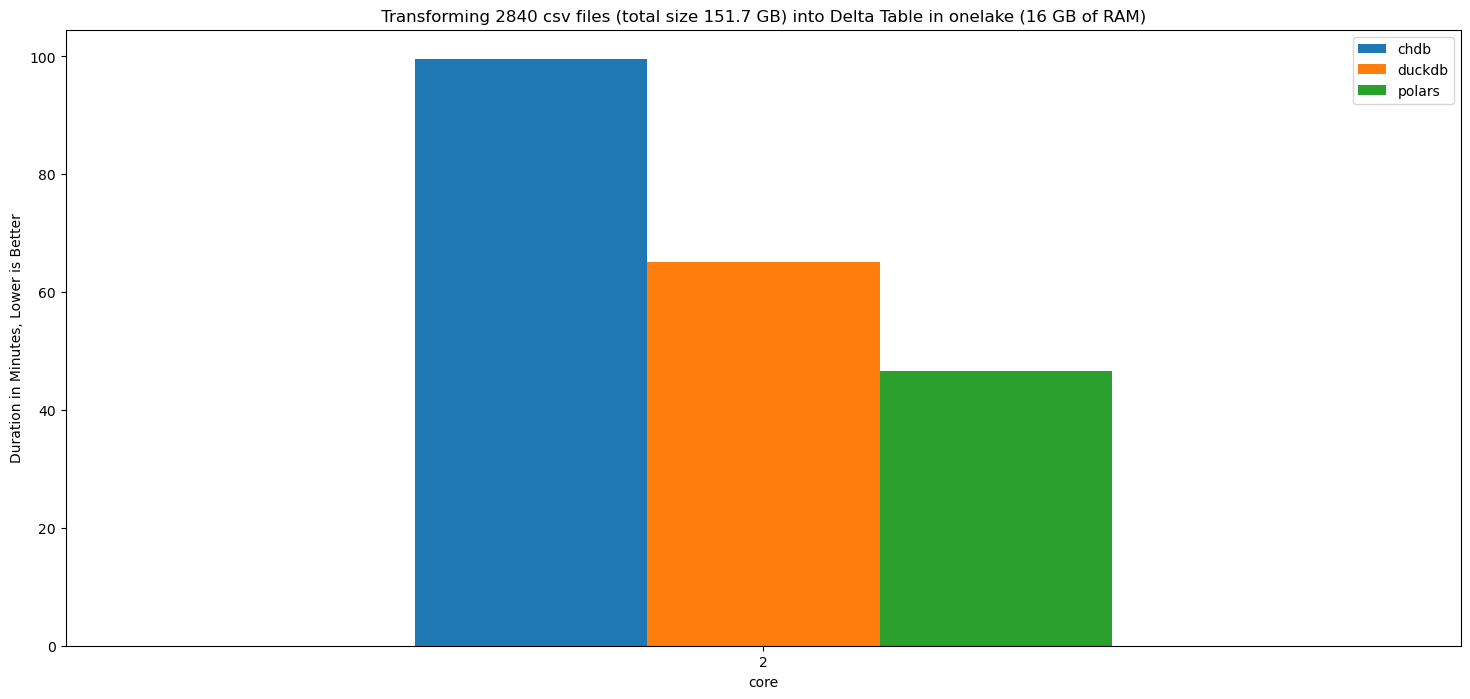

In [23]:
result = duckdb.sql(f""" 
                                   with raw as (
                                   select Engine, core,step, avg(duration) as duration,total_files
                                   from delta_scan('{test_resuts}')
                                   where core = 2
                                   and Engine not in ('ducklake','spark_local')
                                   and total_files = {total_files}
                                   group by all),
                                   result as (
                                   select Engine,core, sum(duration)/60 as duration from raw group by all order by duration)
                                   pivot result on Engine using avg(duration) order by core desc 
                    """).df()
ax = result.plot.bar(rot=0,x='core',title=f" Transforming {total_files} csv files (total size {size(generate_list_path(total_files))} GB) into Delta Table in onelake (16 GB of RAM) ",ylabel='Duration in Minutes, Lower is Better',figsize=(18,8))